# Lab: Estimating a binary choice model using Biogeme

In this lab, we will learn how to estimate a binary choice model using the software [Biogeme](https://biogeme.epfl.ch). We will be working with the Evacuation data experiment, and learn how to: 

* Analyze the data 
* Formulate utility functions
* Define parameters and variables 
* Set availability conditions
* Run the model
* And finally, interpret the results. 


## Requirements

Before starting, make sure that you have all required packages to run this notebook. We recommended creating a new environment to avoid packages clashing with each others. 
We will be using **PandasBiogeme 3.2.14**. To install, you can run `pip install biogeme`in your terminal, or Anaconda navigator. You can also run the following cell to install a package directly in this jupyter notebook. 

In [1]:
#!pip install biogeme  
#Uncomment this cell to install biogeme in the notebook, keeping the ! command at the beginning of the line 

In [2]:
#Check which version of biogeme you're running in this notebook
from biogeme.version import get_text
print(get_text())

biogeme 3.2.14 [2024-12-17]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



We will start by important all the required libraries (**pandas**, **numpy**, and **matplotlib**), and biogeme modules and objects.


In [3]:
import matplotlib
import pandas as pd
import numpy as np

import biogeme.database as db
import biogeme.biogeme as bio

import matplotlib.pyplot as plt 

from biogeme.expressions import Variable
from biogeme import models
from biogeme.expressions import Beta, bioDraws, PanelLikelihoodTrajectory, MonteCarlo,log
from biogeme.parameters import Parameters

#Style for all plots in notebook
matplotlib.style.use('ggplot')

#Set random seed for reproducible results
np.random.seed(seed=1234)


## Data exploration and preparation

We will load the data into a Pandas Dataframe. Dataframes are powerful and flexible objects to store, manipulate and visualize data. Dataframes can be created in multiple ways. Here, we will import the CSV containing our data. We will do so by using the `read_csv` method provided by Pandas. 

*NB: Make sure that the CSV is included in the same folder as this notebook, or change the path to the file in the following cell*

In [4]:
data = pd.read_csv("CEE377_Lab1_Data.csv")

Let's have a look at the dataset. We can use the function `head()` to display the first 5 rows of the dataset. You can also specify a specific number of row as an argument, e.g. `data.head(10)` displays the first 10 rows. 

The dataset contains an identifying column **INDIV_ID**. As you can see, there are multiple observations for the same individual (corresponding to the responses to each experiment). This means that we are dealing with **panel data**, which has some implications on the model formulation. You saw in class that alternatives are assumed to be I.I.D., but in this case, they are not independent: many observations are correlated as they share the same individual-specific attributes. You will see later how to deal with these correlations.

The choice is given by the column **ALT**, which takes the value **1** of the person chose to evacuate, and **2** if the person chose to stay. 

In [5]:
data.head(10)

,INDIV_ID,ALT,COST,DISTANCE,WAITTIME,TRAVELTIME,SHAREFRONT,SHAREBACK,PRIVATE,URGENCY,...,AREA,HH_SIZE,VEHICLES,REP,DEM,CHILDREN,ELDERLY,DISABILITY,NONENGLISH,PETS
0,2,1,40,0.50,0,60,0,0,1,3,...,3,2,2,0,0,0,1,0,0,1
1,2,2,0,0.25,60,40,0,0,1,1,...,3,2,2,0,0,0,1,0,0,1
2,2,2,0,0.50,60,40,0,1,0,1,...,3,2,2,0,0,0,1,0,0,1
3,2,2,0,0.25,30,60,1,0,0,2,...,3,2,2,0,0,0,1,0,0,1
4,2,2,0,0.50,30,20,0,0,1,2,...,3,2,2,0,0,0,1,0,0,1
5,2,2,40,0.50,0,60,0,1,0,2,...,3,2,2,0,0,0,1,0,0,1
6,17,1,40,0.00,60,40,0,0,1,3,...,2,4,3,0,1,1,0,0,0,1
7,17,2,0,0.25,60,40,0,0,1,1,...,2,4,3,0,1,1,0,0,0,1
8,17,2,0,0.50,60,40,0,1,0,1,...,2,4,3,0,1,1,0,0,0,1
9,17,2,0,0.25,30,60,1,0,0,2,...,2,4,3,0,1,1,0,0,0,1


You can use the dataframe attribute `columns` to display the column names. These will be potential features to include in our model. 

Some features are **attributes** of the alternatives, meaning that the value they take depend on the choice. For example, it's the case of the attributes **COST** or **TRAVEL TIME**. Other features are **socio-economic variables**. They characterize the individual and therefore do not vary with the alternatives. For example, **GENDER**, **INCOME** are socio-economic variables. 

The category of feature will dictate how we include them in the utility functions. Only the difference in utilities matters when we're estimating the discrete choice model, and socio-economic variables are constant with respect to the alternatives -- meaning that they would be canceled out when we're looking at utility differences. We therefore need to include them in a way that creates a difference in utility. If you have *n* alternatives, this is typically done by including the socio-economic variable in at most *n-1* alternatives.

In [6]:
data.columns

Index(['INDIV_ID', 'ALT', 'COST', 'DISTANCE', 'WAITTIME', 'TRAVELTIME',
       'SHAREFRONT', 'SHAREBACK', 'PRIVATE', 'URGENCY', 'PEERCHOICE_GO',
       'PEERCHOICE_STAY', 'PAUSING', 'REOPENING', 'REOPENED', 'THREAT',
       'GENDER', 'AGE', 'INCOME', 'EMPLOYMENT', 'RACE', 'HISPANIC', 'AREA',
       'HH_SIZE', 'VEHICLES', 'REP', 'DEM', 'CHILDREN', 'ELDERLY',
       'DISABILITY', 'NONENGLISH', 'PETS'],
      dtype='object')

Let's have a look at the **types** of these features. As you can see, all of them are **numerical**. However, for modeling purposes, it is important to distinguish **continuous variables** from **categorical variables**. 

- Continuous variables (such as **DISTANCE**), that are also attributes, can be included in the utility functions without further transformation. 
- Continuous socio-economic variables (such as **AGE**), can be included as such but not in all alternatives (see above). 
- Categorical variables can be of 2 types: **nominal** or **ordinal**. If ordinal, a ranking is implied and they can be treated as numerical data (e.g. **URGENCY**). If they are nominal, there is no ranking between categories (e.g. **GENDER**). If we include them as such, the model may assume an inherent order or relationship between the categories. There are different ways to avoid this and make sure that the model treats the categories as distinct. At the preprocessing stage, we can **one-hot encode** the variable, meaning that we create new dummy binary variables for each category. This new variable takes the value 1 if the individual belongs to the given category, and 0 otherwise (e.g. **HISPANIC**). You'll see later during the course that steps can be taken also during the modeling process (segmentation).

Let's create a new column **FEMALE**, which takes the value 1 when the **GENDER** is 2.

We can create a column by directly calling it with the following syntax: `dataframe["column name"]` or `dataframe.loc[:, "column_name"]`. The right-hand side of the expression is a condition on the gender column. `(data['GENDER']==2)` returns a *boolean* (True/False variable), that is True if Gender is 2. We multiply this boolean by 1 to transform it into a numerical value.

In [7]:
data['FEMALE'] = (data['GENDER']==2)*1

In [8]:
data[['GENDER', 'FEMALE']].head()

,GENDER,FEMALE
0,2,1
1,2,1
2,2,1
3,2,1
4,2,1


If you're dealing with more than 2 categories, it will be faster to use pandas' [`get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function.

For example, we can create dummies out of the **INCOME** variable, which has 13 categories. 


In [9]:
pd.get_dummies(data['INCOME'], prefix= "INCOME")*1

,INCOME_0,INCOME_1,INCOME_2,INCOME_3,INCOME_4,INCOME_5,INCOME_6,INCOME_7,INCOME_8,INCOME_9,INCOME_10,INCOME_11,INCOME_12
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0,0,0,0,0,1,0,0,0,0,0,0,0
710,0,0,0,0,0,1,0,0,0,0,0,0,0
711,0,0,0,0,0,1,0,0,0,0,0,0,0
712,0,0,0,0,0,1,0,0,0,0,0,0,0


We will now use the `describe()` function to get a statistical overview of the data. Here, we are selecting only the socio-economic variables from the dataframe.

In [10]:

data[['GENDER', 'AGE', 'INCOME', 'EMPLOYMENT', 'RACE', 'HISPANIC', 'AREA',
       'HH_SIZE', 'VEHICLES', 'REP', 'DEM', 'CHILDREN', 'ELDERLY',
       'DISABILITY', 'NONENGLISH', 'PETS']].describe()

,GENDER,AGE,INCOME,EMPLOYMENT,RACE,HISPANIC,AREA,HH_SIZE,VEHICLES,REP,DEM,CHILDREN,ELDERLY,DISABILITY,NONENGLISH,PETS
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,1.495798,2.260504,5.630252,1.798319,1.705882,0.050420,1.983193,2.831933,1.731092,0.142857,0.546218,0.218487,0.126050,0.134454,0.067227,0.470588
std,0.532910,1.357306,3.107785,1.186033,0.999464,0.218964,0.686269,1.292893,1.010721,0.350172,0.498208,0.413510,0.332139,0.341378,0.250590,0.499484
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,5.000000,1.000000,1.000000,0.000000,2.000000,3.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,3.000000,8.000000,2.000000,3.000000,0.000000,2.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,6.000000,12.000000,5.000000,4.000000,1.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot some distributions. The main plotting library for Python is **matplotlib**. It's highly customizable and supports various types of plots, such as line graphs, bar charts, histograms, and scatter plots. 

Let's plot the distribution of **number of vehicles per household**. We start by extracting the frequency of each number of vehicles by using the function `value_counts()`, and plot it in a bar graph. 

In [11]:
veh_counts = data['VEHICLES'].value_counts().sort_index()
veh_counts

VEHICLES
0     84
1    204
2    276
3    120
4     30
Name: count, dtype: int64

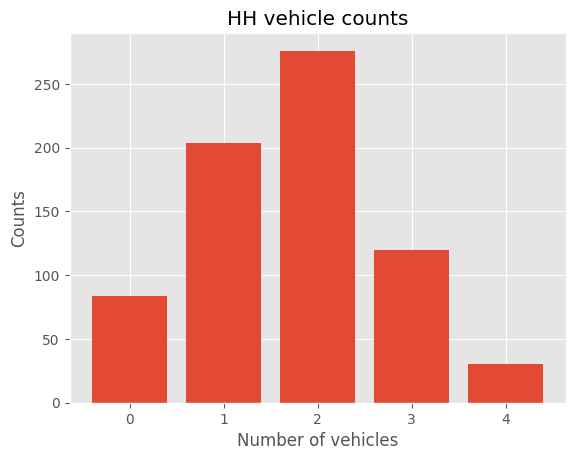

In [12]:
plt.bar(range(5), height = veh_counts)

plt.title("HH vehicle counts")
plt.xlabel("Number of vehicles")
plt.ylabel("Counts")

plt.show()

You can also very quickly produce the same plot directly from the dataframe, calling the ``plot()`` function.

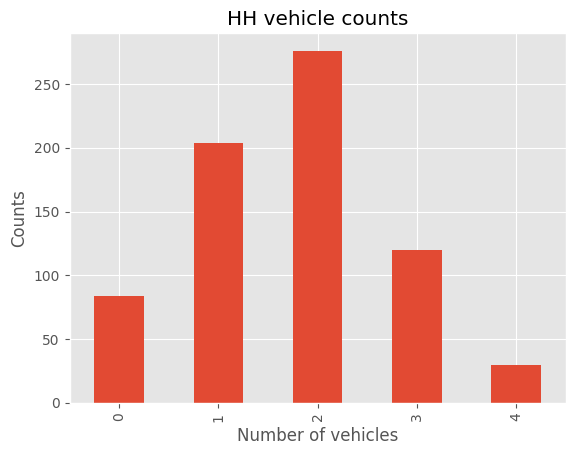

In [13]:
ax = data['VEHICLES'].value_counts().sort_index().plot(kind='bar',title="HH vehicle counts")
ax.set_xlabel("Number of vehicles")
ax.set_ylabel("Counts")

plt.show()

You can plot multiple figures at once with the `subplots()` function. Here, we plot the distribution of **INCOME**, **EMPLOYMENT**, **RACE** and **RESIDENTIAL AREA**. 

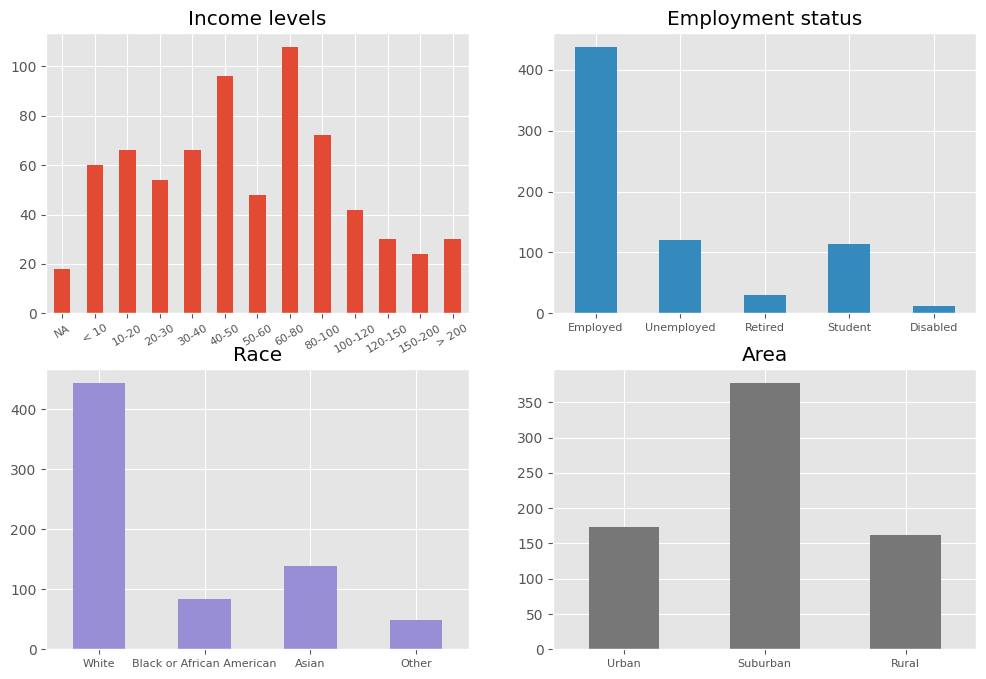

In [14]:
income_labels = {0: "NA", 
                 1: "< 10", 
                 2: "10-20",
                 3:"20-30", 
                 4: "30-40", 
                 5:"40-50",
                 6: "50-60",
                7: "60-80",
                8: "80-100",
                9:"100-120",
                10: "120-150",
                11: "150-200", 
                12: "> 200"}

employment_labels = {1: "Employed", 
                     2: "Unemployed",
                     3: "Retired",
                     4: "Student",
                     5: "Disabled"}

race_labels = {1:"White", 
               2: "Black or African American",
               3: "Asian",
               4: "Other"}

area_labels = {1: "Urban", 2: "Suburban", 3: "Rural"}

#Create suplots with 2 rows and 2 columns
fig, axes = plt.subplots(2,2, figsize = [12,8])

#Count values for each income level, and plot a bar that will be passed to the first subplot position (0,0)
data["INCOME"].value_counts().sort_index().plot(kind = "bar", title = "Income levels", 
                                                      color = 'C0', ax = axes[0,0], xlabel = '')
#Add the category labels to the x-axis
axes[0,0].set_xticklabels(income_labels.values(), rotation = 30, fontsize = 8)

#Repeat :) (this could be done more efficiently with a for-loop)
data["EMPLOYMENT"].value_counts().sort_index().plot(kind = "bar", title = "Employment status", 
                                                    color = 'C1', ax = axes[0,1],  xlabel = '')
axes[0,1].set_xticklabels(employment_labels.values(), rotation = 0, fontsize = 8)

data["RACE"].value_counts().sort_index().plot(kind = "bar", title = "Race", color = 'C2', ax = axes[1,0],  xlabel = '')
axes[1,0].set_xticklabels(race_labels.values(), rotation = 0, fontsize = 8)

data["AREA"].value_counts().sort_index().plot(kind = "bar", title = "Area", color = 'C3', ax = axes[1,1],  xlabel = '')
axes[1,1].set_xticklabels(area_labels.values(), rotation = 0, fontsize = 8)

plt.show()

## Initial Biogeme model

Now that we have a better idea of what the data looks like, let's set up our first model. To illustrate how to use Biogeme to define and estimate your models, we will start with a very simple estimation of a **binary choice model**, where there are only 2 alternatives **EVACUATE** (ALT = 1) or **STAY** (ALT = 2). 

We will initially ignore the socio-economic variables, and focus on the attributes of the alternatives. 

We will create a **Biogeme database** by importing our Pandas dataframe. We will call this database *Evacuation*. Biogeme requires data to be in **wide** format, meaning that we should only have one row per observation/individual. Because our data has multiple observations for the same individual, we declare it as a panel dataset, where the identifying column is **INDIV_ID**.

In [15]:
biog_database = db.Database('evacuation',data)
biog_database.panel('INDIV_ID')

### Variables 
We can now start defining our model. We need to declare 3 elements: variables, parameters and utility functions. 

You can declare **variables** by creating a Biogeme `Variable`object, that takes as argument the column label corresponding to the variable. We illustrate this by creating the cost variable and the choice. 

To make the model more readable, we advise you to give your variables the same names as the database column *if you don't perform any transformation* on them. 

If you want to create a new variable (non-existing in your database), you can use the ``define_variable()``, which takes as argument the name of the variable and a *Biogeme expression* to define it. We will for example create a new variable **COST_SCALED**, which is obtained by dividing the cost by 100. 


In [16]:
#Variables 
COST = Variable('COST')
ALT = Variable('ALT')

#New variable
COST_SCALED = biog_database.define_variable('COST_SCALED', COST/100)

### Parameters
Secondly, we will create the parameters to be estimated. This is done by declaring a new **Beta** object, which takes as argument the name of the parameter, the initial value (most of the time, this value can be left at 0, except in some specific cases that you will encounter later in the course), the lower and upper bound, and whether the parameter should be estimated (0) or fixed (1). If it is fixed, the initial value that you've defined will bed used.

Here, we will only consider the **COST** parameter, and the **alternative-specific constants (ASC)**. We decide to set the **STAY** alternative as the reference, meaning that its corresponding ASC is 0.

In [17]:
#Parameters to be estimated

B_COST = Beta('B_COST', 0, None, None, 0)

#Stay is the reference alternative, so the last argument is 1
ASC_STAY = Beta('ASC_STAY', 0, None, None, 1)
ASC_GO = Beta('ASC_GO', 0, None, None, 0)


### Utility functions

Now that we have defined our parameters, let's set up our **utility functions**. As a reminder, for each individual $n$, the utility function of alternative $i$ is expressed as:

$U_{i,n} = V_{i,n} + \varepsilon_{i,n}$

where $V_{i,n}$ is the deterministic utility and $\varepsilon_{i,n}$ is an error term. In Biogeme, we only define $V_{i,n}$, as the error terms are automatically dealt with by the software when we are estimating simple models (in the case of a binary logit model, we have I.I.D Extreme Value distributed errors). 

In our problem, the utility functions are defined as follows: 

- $V_\text{stay} = \text{ASC}_\text{stay}$
- $V_\text{go} = \text{ASC}_\text{go} + \beta_\text{COST}*\text{COST}$

In Biogeme, you can directly define the utility vectors as a function of the Variable and Beta objects. 

*NB: Recall that we have a panel dataset, meaning that the I.I.D. assumption for the error terms is violated here. This correlation can be explicitly dealt with by estimating random ASCs. To simplify this lab, we ignore this correlation.*

In [18]:
#Definition of utility function vectors 
V_STAY = ASC_STAY 
V_GO = ASC_GO + B_COST*COST

We now need to associate these utility functions with the alternative numbers as defined in our data (**ALT** column). As a reminder, **1** is for the **Evacuate** alternative, and **2** for the **Stay** option. We also need to define **availability conditions** for each alternatives. If the alternative is available to all individuals in your dataset, you can just set the availability to **1**, as we've done here. There are cases where alternatives may not always be available. You can imagine for example a mode choice experiment where individuals without a driving license are not allowed to choose the car as an option. 

In [19]:
#Associate utility functions with numbering of alternatives
V = {1: V_GO, 2: V_STAY} 

#Associate the availability conditions with the alternatives
av = {1: 1, 2: 1}

### Model estimation 

We can now estimate our model. We start by creating the **logit** choice probabilities, from the models module of Biogeme. As a reminder, the choice probability of a logit model for alternative $i$ is: 

$P_{in} = \frac{e^{V_{in}}}{\sum_j e^{V_{jn}}}$

and the likelihood is defined as the product of probabilities over each alternative and individual:

$L = \prod_i \prod_n P_{in}$

The model takes as arguments the dictionary with the utility functions, the availability conditions and the individual choices.  To avoid numerical issues, we usually implement the log of the probilities, and the **log likelihood**

$\log{L} = \sum_i \sum_n P_{in}$

*NB: Because we're working with panel data, we need to add an intermediate line to calculate the likelihood for each individual, to include the contribution of each observation*

In [20]:
obsprob =models.logit(V, av, ALT) 

#The likelihood of all observations for one individual (the trajectory) is the product of the likelihood of each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)

#take the log of the probability
logprob = log(condprobIndiv)

Given the data, we estimate the maximum likelihood estimators of the parameters.

In [21]:
the_biogeme = bio.BIOGEME(biog_database, logprob)
the_biogeme.modelName = 'evacuation'

# Estimate the parameters.
results = the_biogeme.estimate()

### Results

Running `estimate()`returns a Biogeme **results** object, from which you can extract summary statitistics and metrics (final log likelihood, AIC, BIC, $\rho^2$...), the estimated parameters, etc. The model will also output 2 files: 
- A *html* file, with the complete estimation output.
- A *pickle* file, which contains the model as a python object. The pickle file will be very useful when we want to use calibrated models (for simulation for example).

In [22]:

print(results.short_summary())


Results for model evacuation
Nbr of parameters:		2
Sample size:			119
Observations:			714
Excluded data:			0
Final log likelihood:		-474.1464
Akaike Information Criterion:	952.2929
Bayesian Information Criterion:	957.8511



In [23]:
results.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_GO,-0.727085,0.141324,-5.144820,2.677773e-07
B_COST,0.016344,0.004724,3.460084,5.400068e-04


How do we make sure that our model is "good"? Fit statistics give you a good indication of this, but studying the parameter estimates that you obtain is also important. A few questions that you can ask yourself:
- Are the parameters interpretable, do they make sense?
- Do they match my assumptions on behavior?
- Are they consistent with the observations?
  
In this case, we can see that both parameters are statistically significant at a 95% level of significance ($|\text{Rob. t-test}| > 1.96 $ or $|\text{p-value}| < .05 $ ). Note that the $t$ statistic provided by Biogeme is testing the parameter against 0.

The ASC for the *go* alternative is negative, meaning that, all else being equal, people have a preference for staying instead of evacuating. The cost parameter is positive, indicating an increasing utility for evacuating when the cost increases. This result is somewhat counterintuitive. It could indicate a higher sense of urgency with a higher cost. But it could also (more likely) mean that there are some significant influences that we are not accounting for with our model. 


## Second model: Impact of travel time attribute

Our model is too simple to properly capture all the influences on the choice of staying or evacuating. We will start by testing how including a second attribute (**travel time**) into the utility functions affects our estimations. 


In [24]:
#Extract travel time variable
TRAVEL_TIME = Variable('TRAVELTIME')

#Define travel time parameter
B_TIME = Beta('B_TIME', 0, None, None, 0)

#Update utility functions
V_STAY = ASC_STAY 
V_GO = ASC_GO + B_COST*COST + B_TIME * TRAVEL_TIME

V = {1: V_GO, 2: V_STAY} 
av = {1: 1, 2: 1}

#Estimate model
obsprob =models.logit(V, av, ALT) 
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(condprobIndiv)

the_biogeme = bio.BIOGEME(biog_database, logprob)
the_biogeme.modelName = 'evacuation_time'

results = the_biogeme.estimate()

#Print results
print(results.short_summary())


Results for model evacuation_time
Nbr of parameters:		3
Sample size:			119
Observations:			714
Excluded data:			0
Final log likelihood:		-468.6275
Akaike Information Criterion:	943.255
Bayesian Information Criterion:	951.5924



In [25]:
results.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_GO,0.035587,0.255702,0.139175,0.889312
B_COST,0.014622,0.005165,2.831095,0.004639
B_TIME,-0.017943,0.004606,-3.895793,0.000098


### Testing significance and comparing models 

It's important to compare our models, by testing if our assumptions for the new specification make sense (is the parameter statistically significant?), and if it improves the fit of the model as compared to leaving it out. As a rule of thumb, if you have two models with comparable fits, you want to choose the simpler model (usually, the one with fewer parameters). 

When evaluating our second model, we are testing the following null ($H_0$) and alternative ($H_1$) hypotheses at a 95% level of significance: 

- $H_0 : \beta_\text{time} = 0$
- $H_1 : \beta_\text{time} \neq 0$

We can focus on the robust T statistic to perform a *t-test* against 0. Here, we see that $\text{|Rob. t| > 1.96}$, meaning that we can reject the null hypothesis at the 95% level of significance. 

When the only difference between two models is a parameter, performing a t-test of significance is usually sufficient to compare the models. In other cases, another useful test is to compare the tradeoff between the addition of this parameter and the improvement of the model fit by performing a **log-likelihood ratio-test**.

$\text{LR} = - 2*(\text{LL}_\text{restricted} - \text{LL}_\text{unrestricted})$

The LR statistic is compared to a [critical value from the $\chi^2$ distribution](https://math.arizona.edu/~jwatkins/chi-square-table.pdf). **Careful:** The LR test can only be performed to compare **nested** models, meaning that one model must be a linear restriction of the other. In our case, the original model ($M_1$) is a linear restriction of our second model ($M_2$), because you can go from one to the other only by adding or subtracting the travel time component. 

In [26]:
LR = -2*(-474.1464 + 468.6275)
LR

11.037800000000061

Because we have 1 degree of freedom (number of restrictions) between $M1$ and $M2$, at the 95% level of significance the $\chi^2$ critical value is 3.841. 
We have $11.037 > 3.841$, confirming that we can reject $H_O$.

## Third model: Impact of car ownership level

In this model, we assume that the number of cars owned will affect the choice, by reducing the probability of staying. This model corresponds to the following hypotheses: 

- $H_0 : \beta_\text{vehicles} = 0$
- $H_1 : \beta_\text{vehicles} \neq 0$

In [27]:
#Extract travel time variable
VEHICLES = Variable('VEHICLES')

#Define travel time parameter
B_VEHICLES = Beta('B_VEHICLES', 0, None, None, 0)

#Update utility functions
V_STAY = ASC_STAY + B_VEHICLES*VEHICLES 
V_GO = ASC_GO + B_COST*COST + B_TIME * TRAVEL_TIME

V = {1: V_GO, 2: V_STAY} 
av = {1: 1, 2: 1}

#Estimate model
obsprob =models.logit(V, av, ALT) 
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(condprobIndiv)

the_biogeme = bio.BIOGEME(biog_database, logprob)
the_biogeme.modelName = 'evacuation_vehicles'

results = the_biogeme.estimate()

#Print results
print(results.short_summary())


Results for model evacuation_vehicles
Nbr of parameters:		4
Sample size:			119
Observations:			714
Excluded data:			0
Final log likelihood:		-468.5747
Akaike Information Criterion:	945.1493
Bayesian Information Criterion:	956.2658



In [28]:
results.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_GO,0.080438,0.306110,0.262774,0.792725
B_COST,0.014536,0.005173,2.809961,0.004955
B_TIME,-0.017938,0.004604,-3.896215,0.000098
B_VEHICLES,0.025114,0.090669,0.276985,0.781791


We can make several observations: 
- The likelihood has barely improved between this model and the previous one.
- The paramerers for the number of vehicles is not statistically significant ($|t| < 1.96$ and $p > .05$).

In [29]:
LR = -2*(-468.6275 +468.5747)
LR

0.10559999999998126

We have $0.106 < 3.841$, meaning that the LR test also failed. This indicates that we would discard this specification and keep the simpler one with only the cost and travel time.

# Independent work 

We're arriving at the end of this demonstration. It's now your turn to explore the modeling possibilities to explain this choice problem: 

1. Explore the data: can you think of a few ideas (hypothesis) you want to test?
2. Build models in Biogeme: modify the provided code to define and test one idea about attributes, and one about socio-demographic
3. Interpret the results, and perform appropriate tests to decide which model to keep.

# Resources

- You can find very useful resources for Biogeme directly [on the website](https://biogeme.epfl.ch), including the full documentation, templates for a variety of models, datasets, and a [techical report](https://transp-or.epfl.ch/documents/technicalReports/Bier23.pdf) to help you getting started. 
- Further reading on discrete choice models: [Train, K. E. (2009). Discrete choice methods with simulation. Cambridge university press. ](https://eml.berkeley.edu/books/train1201.pdf)
- Cheat sheets: [Python](https://www.pythoncheatsheet.org/cheatsheet/basics), [Pandas](https://media.datacamp.com/legacy/image/upload/v1676302204/Marketing/Blog/Pandas_Cheat_Sheet.pdf), [Matplotlib](https://media.datacamp.com/legacy/image/upload/v1676360378/Marketing/Blog/Matplotlib_Cheat_Sheet.pdf), [Jupyter notebook](https://media.datacamp.com/legacy/image/upload/v1676302533/Marketing/Blog/Jupyterlab_Cheat_Sheet.pdf)